Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_1, Layer Type: InputLayer
Index: 1, Layer Name: stem_conv1, Layer Type: Conv2D
Index: 2, Layer Name: stem_bn1, Layer Type: BatchNormalization
Index: 3, Layer Name: activation, Layer Type: Activation
Index: 4, Layer Name: reduction_conv_1_stem_1, Layer Type: Conv2D
Index: 5, Layer Name: reduction_bn_1_stem_1, Layer Type: BatchNormalization
Index: 6, Layer Name: activation_1, Layer Type: Activation
Index: 7, Layer Name: activation_3, Layer Type: Activation
Index: 8, Layer Name: separable_conv_1_pad_reduction_left1_stem_1, Layer Type: ZeroPadding2D
Index: 9, Layer Name: separable_conv_1_pad_reduction_right1_stem_1, Layer Type: ZeroPadding2D
Index: 10, Layer Name: separable_conv_1_reduction_left1_stem_1, Layer Type: SeparableConv2D
Index: 11, Layer Name: separable_conv_1_reduction_right1_stem_1, Layer Type: SeparableConv2D
Index: 12, Layer Name: separable_conv_1_bn_reduction_l

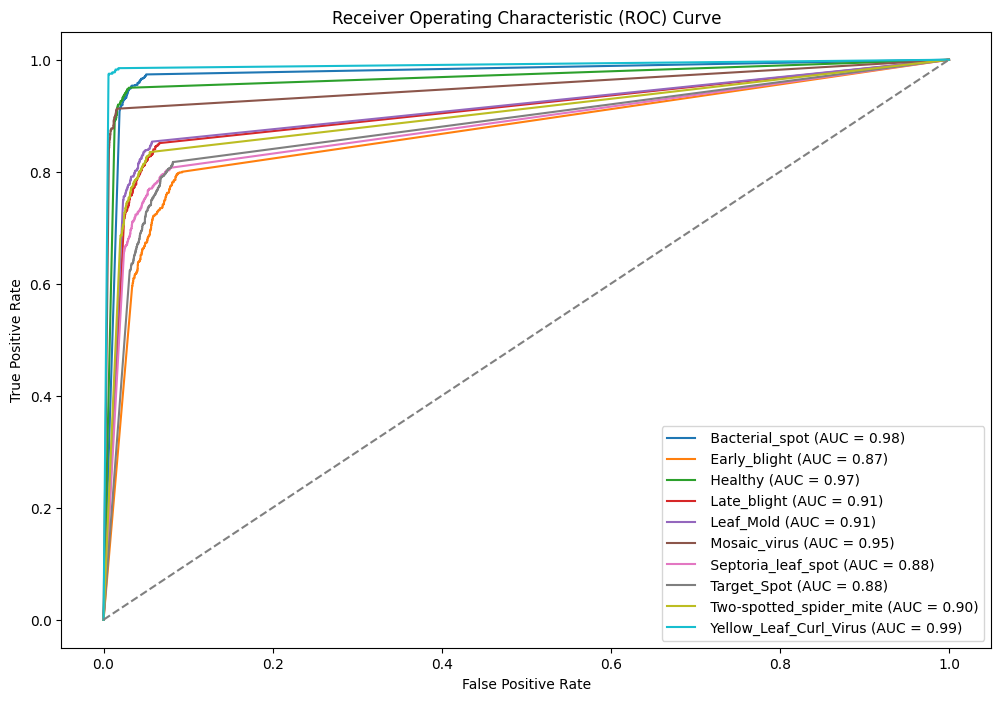

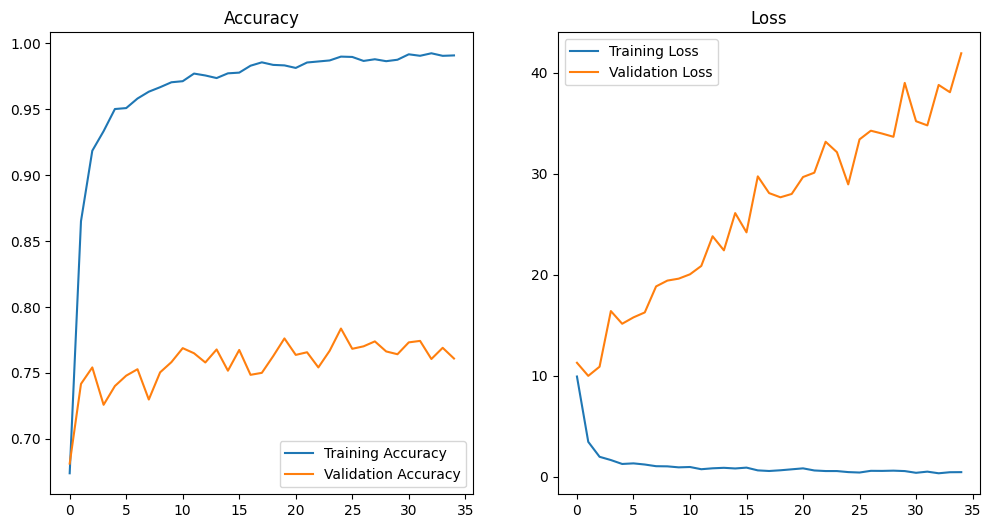

84/84 [==============================] - 116s 1s/step - loss: 28.9326 - accuracy: 0.7836
Final Validation Accuracy: 0.7836
Final Validation Loss: 28.9326
84/84 [==============================] - 115s 1s/step
Confusion Matrix:
[[740  10   1   8   0   0  21   2   1  17]
 [ 47 512   5  98  32   3  36  45  17   5]
 [  3   6 722   1   5   3   7  36  15   2]
 [ 14  89   7 589  40   3  35  15   2   6]
 [  6  41   7  24 612  22  36  35  13   4]
 [  0  12   8   2  44 690  12   4  20   8]
 [ 45  74   8  53  25   3 539  28  18   7]
 [ 36  55  47  11  21   2  26 526  70   6]
 [  7  17  28   9  25  16  28 105 559   6]
 [  4   0   2   0   0   4   2   2   6 780]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       800
           1       0.63      0.64      0.63       800
           2       0.86      0.90      0.88       800
           3       0.74      0.74      0.74       800
           4       0.76      0.77      0.76      

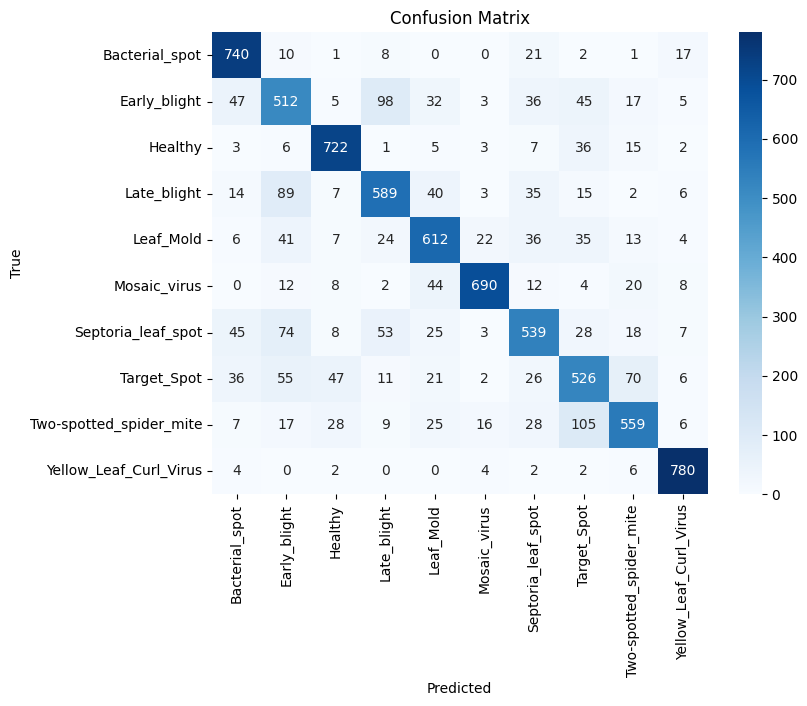

In [1]:
#NASNetLarge
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (331, 331)
batch_size = 96
num_classes = 10
# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = NASNetLarge(include_top=False, weights="imagenet", input_shape=(331, 331, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./NASNetLarge.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./NASNetLarge.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)